# open-science-prize-21 
### (gate based solution)  

## Author
Minxi Yang (yang1452@purdue.edu)
### Overview

In IBM open-science-prize-21, the $XXX$ Heisenberg model is asked to be simulated on the IBM Jakarta. 
The goals of this challenge 
is that simulated 3 sites Heisenberg model using at least 4 steps of the 
trotterization on qubit 1, 3, 5 of the IBM Jakarta and obtain the best fidelity for the initial state |110> 
and simulation time $\pi$. <br/>

In my solution, I handle the challenge by three steps.

1. Circuit compression technique: As we known, the near-term quantum computing suffer from the noise. The largest 
noise ususally come from the decay of the qubit. Thus, the circuit layout optimization is the key point to 
reduce the total gate time and obtain a good fidelity. In this solution, I developed and implemented a 
circuit compression technique which allows that the any steps of trotterization to be represented a circuit with the constant 
depth of the CNOT gate. The papers [] motivate me to come up with this idea, however my solution is new and different from the paper since the paper's solution cannot apply on the $XXX$ Heisenberg model. In my solution, an analytical form of the mirror relation with five blocks instead of three for three qubits in the paper is found.  
With this mirror relation, any number of the steps can be compressed and represented a 15 CNOTs circuct. In my solution, totally 
64 steps of the second-order trotterization are compressed and represented by a circuit with total 15 CNOTs and the computation time is about 5 minutes.  

2. Dynamic decoupling: Dynamic decoupling (DD) is a technique which uses the periodic pulse to filp the qubit and 
neutralized the bath-system interaction []. The T1 and T2 lifetime of the qubit is supposed to be extended with the DD.
In my solution, I implement the DD with $XYXY$ series by hand on qubit 1, 3 and the ancillary qubit 4[].  
    
3. Post-processing: A error mitigation with the official qiskit mitigation tool is performed with the qubit 1, 3, 5 
and ancillary qubit 4 to supress the readout error. After the error mitigation, the symmetry verfication is 
applied[]. In this techique, the state of one ancillary qubit is used to check if the envolution of the state 
statisfy the specific symmetry that the target Hamitonian have. In this solution, qubit 4 is used as the ancillary 
qubit. All the shots which do not pass the verfication are selected out before the StateTomographyFitter.fit().
<br/>
The solution is generalized to take any input state and envolution time, and do not use any information of
the input state and the noiseless output state. In pricinpal, it can work well with unknown input and output state. The solution is low-cost and only the target circuits and the circuits for the readout error measurement are running.   
Beside the target state and envolution time, the fidelity for the target state and envolution time $\pi/2$,
and the input state (|110> + |010>)/$\sqrt{2}$ with the target envolution time are also tested. The final results are shown below.
1. Target state and time without DD: state tomography fidelity = $0.9224 ± 0.0045$
2. Target state and time with DD: state tomography fidelity = $0.9101 ± 0.0047$
3. Target state and $\pi/2$ time with DD: state tomography fidelity = $0.9049 ± 0.0046$
4. |110>+|010>/$\sqrt{2}$ state and target time with DD: state tomography fidelity = $0.8896 ± 0.0066$


The results are suprisedly better than I expected (even better than the noise simulation). The version of the solution without DD has better performance that with the DD. However, I still keep DD as part of my final solution since I test DD in the individual qubit and the fidelity increase. The calibration of the device is variational and I believe that DD provides improvement overall. 


In [108]:
# import all the packages

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts
# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile, ClassicalRegister
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.visualization import array_to_latex
from qiskit import Aer
import math
import qiskit.quantum_info as qi
from copy import deepcopy
import numpy as np
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.compiler import transpile
from qiskit import schedule
from scipy.optimize import basinhopping
from IPython.display import Image


Here I provide a list of the version of the packages.

1. qiskit  0.34.0
2. numpy  1.21.5
3. scipy  1.7.3
4. matplotlib  3.5.1
5. IPython     7.30.1

In [155]:
# set IBM account and backend

IBMQ.save_account('e79582f33d0739f84c7af8d9948f9ebe1f0aab3a97e0d877805890300992dfffc777393f6441e90f7aa73ad011b28732656030e94f3a5dfb762540dfe5feaba1')  # replace TOKEN with your API token string (https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq)
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
jakarta = provider.get_backend('ibmq_jakarta')
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
sim = QasmSimulator()

configrc.store_credentials:WARNING:2022-04-15 12:37:35,301: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-04-15 12:37:36,356: Credentials are already in use. The existing account in the session will be replaced.


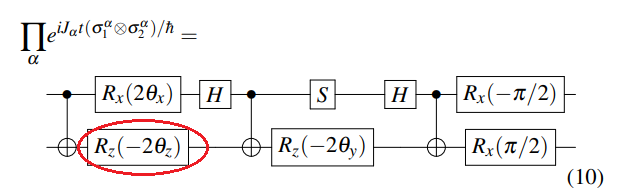

In [160]:
Image(filename='pic/pic1.png')

The optimal circuit of $e^{-i(XX\theta_{1} + YY\theta_{2} + ZZ\theta_{3})}$ from the reference [] is used. Compared the solution from the example, the number of the CNOT gates is reduced from 6 to 3 with the optimal circuit. I notice there is a small error in the reference, the Rz gate labeled by the red circuit should be + $\theta_{z}$.
<br/>

Three such parameterized circuits "XX+YY+ZZ" which represent $e^{-i\beta (XX + YY + ZZ)}$ with parameters $\beta_{1,2,3}$ are built which will be used late.   

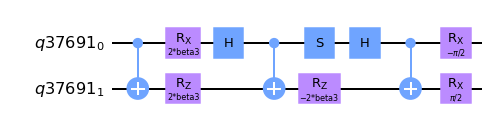

In [128]:
beta1 = Parameter('beta1')
beta2 = Parameter('beta2')
beta3 = Parameter('beta3')

XYZ_qr = QuantumRegister(2)
XYZ_qc = QuantumCircuit(XYZ_qr, name='XX+YY+ZZ')
XYZ_qc.cnot(0,1)
XYZ_qc.rx(2*beta1, 0)
XYZ_qc.rz(2*beta1, 1)
XYZ_qc.h(0)
XYZ_qc.cnot(0,1)
XYZ_qc.s(0)
XYZ_qc.h(0)
XYZ_qc.rz(-2*beta1,1)
XYZ_qc.cnot(0,1)
XYZ_qc.rx(-np.pi/2,0)
XYZ_qc.rx(np.pi/2,1)
XYZ_1 = XYZ_qc.to_instruction()


XYZ_qc = QuantumCircuit(XYZ_qr, name='XX+YY+ZZ')
XYZ_qc.cnot(0,1)
XYZ_qc.rx(2*beta2, 0)
XYZ_qc.rz(2*beta2, 1)
XYZ_qc.h(0)
XYZ_qc.cnot(0,1)
XYZ_qc.s(0)
XYZ_qc.h(0)
XYZ_qc.rz(-2*beta2,1)
XYZ_qc.cnot(0,1)
XYZ_qc.rx(-np.pi/2,0)
XYZ_qc.rx(np.pi/2,1)
XYZ_2 = XYZ_qc.to_instruction()


XYZ_qc = QuantumCircuit(XYZ_qr, name='XX+YY+ZZ')
XYZ_qc.cnot(0,1)
XYZ_qc.rx(2*beta3, 0)
XYZ_qc.rz(2*beta3, 1)
XYZ_qc.h(0)
XYZ_qc.cnot(0,1)
XYZ_qc.s(0)
XYZ_qc.h(0)
XYZ_qc.rz(-2*beta3,1)
XYZ_qc.cnot(0,1)
XYZ_qc.rx(-np.pi/2,0)
XYZ_qc.rx(np.pi/2,1)
XYZ_3 = XYZ_qc.to_instruction()
XYZ_qc.draw('mpl')

I also build a extra circuit "(XX+YY+ZZ)_inv". It is another optimal circuit representation of $e^{-i\beta (XX + YY + ZZ)}$. 
This extra circuit is created by inverting "XX+YY+ZZ" circuit to obtain $e^{i\beta_{1} (XX + YY + ZZ)}$. Then 
change the sign of $\beta_{1}$ to $-\beta_{1}$. 
<br/>
The motivation that I create those circuits will be shown in the following blocks. 

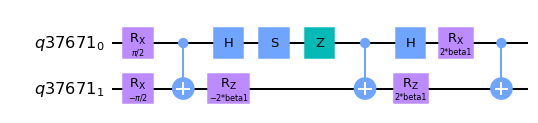

In [115]:
XYZ_qr = QuantumRegister(2)
XYZ_qc = QuantumCircuit(XYZ_qr, name='(XX+YY+ZZ)_inv')
XYZ_qc.rx(-np.pi/2,1)
XYZ_qc.rx(np.pi/2,0)
XYZ_qc.cnot(0,1)
XYZ_qc.rz(-2*beta1,1)
XYZ_qc.h(0)
XYZ_qc.s(0)
XYZ_qc.z(0)
XYZ_qc.cnot(0,1)
XYZ_qc.h(0)
XYZ_qc.rz(2*beta1, 1)
XYZ_qc.rx(2*beta1, 0)
XYZ_qc.cnot(0,1)
XYZ_1_inv = XYZ_qc.to_instruction()
XYZ_qc.draw('mpl')

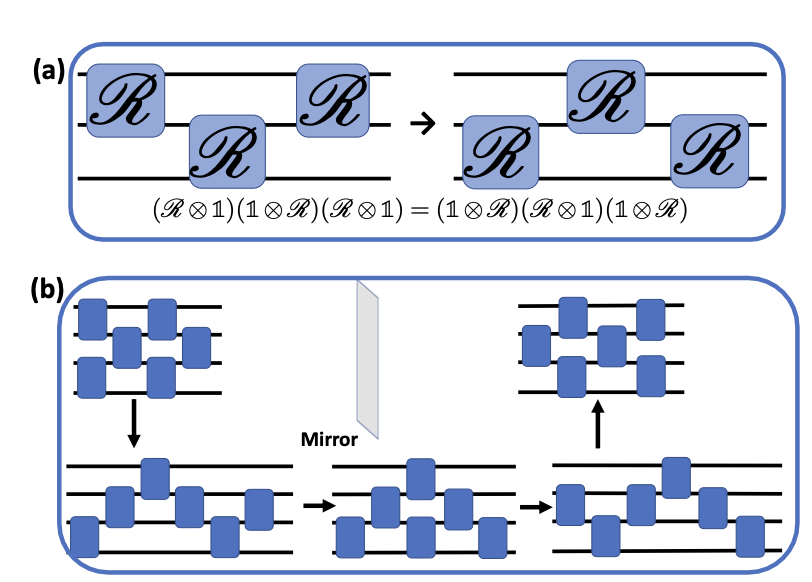

In [161]:
Image(filename='pic/pic2.png')

Yang-Baxter-like mirror relation of the quantum circuit is came up with the reference[]. The main idea for this relation is that try to find a mirrored circuit for the three alternative layers circuit which represents the same unitary operator.     
By applied this mirror relation many times and merge the adjacent blocks, any number of the trotter step can be 
represented by a constant depth.
<br/>
However, the authors of the reference [] only provide the proof and analytical form of this mirror relation for $XY$ Heisenberg model. Unfortuntely, I found that this relation Yang-Baxter-like mirror relation do not exist in $XXX$ Heisenberg model.    

In [5]:
def f1(x, y, z): # I
    
    f = np.cos(2*x)*np.cos(2*y)*np.cos(z) - np.sin(2*x)*np.cos(y)**2*np.sin(z)
    return f

def f2(x, y, z): # pt-1
    

    f = -np.sin(x)**2*np.sin(2*y)*np.cos(z) - np.cos(x)**2*np.sin(y)**2*np.sin(z) - 0.5*np.sin(2*x)*np.sin(2*y)*np.sin(z)
    return f

def f3(x, y, z): # p
    
    f = np.cos(2*x)*np.cos(y)**2*np.sin(z) + np.sin(2*x)*np.cos(2*y)*np.cos(z)
    return f

def f4(x, y, z): # pt 
    
    f = np.cos(x)**2*np.sin(2*y)*np.cos(z) + np.sin(x)**2*np.sin(y)**2*np.sin(z) - 0.5*np.sin(2*x)*np.sin(2*y)*np.sin(z)
    return f

def f5(x, y, z): # t + t-1
    
    
    f = -0.5*np.sin(2*x)*np.sin(2*y)*np.cos(z) - 0.5*np.cos(2*x)*np.sin(2*y)*np.sin(z) + 0.5*np.sin(2*x)*np.sin(y)**2*np.sin(z)
    return f

In [6]:
def mirror(alphas, *betas):
    
    alpha1, alpha2, alpha3 = alphas
    beta1, beta2, beta3 = betas

    eq1 = f1(alpha1, alpha2, alpha3) - f1(beta1, beta2, beta3)
    eq2 = f2(alpha1, alpha2, alpha3) - f2(beta1, beta2, beta3)
    eq3 = f3(alpha1, alpha2, alpha3) - f4(beta1, beta2, beta3)
    eq4 = f4(alpha1, alpha2, alpha3) - f3(beta1, beta2, beta3)
    eq5 = f5(alpha1, alpha2, alpha3) - f5(beta1, beta2, beta3)
    
    return eq1**2 + eq2**2 + eq3**2 + eq4**2 + eq5**2

def compression(n, t):
    
    init_v = -2*t/2**(n+1)
    betas0 = [0.5*init_v, init_v, init_v]
    bounds = [(-np.pi, np.pi), (-np.pi, np.pi), (-np.pi, np.pi)]
    mini_r = []
    for i in range(n):

        betas=[0,0,0]
        betas[0] = betas0[2]
        betas[1] = betas0[1]
        betas[2] = 2*betas0[0]
        betas[2] = (betas[2]+np.pi) % (2*np.pi) - np.pi
        betas = tuple(betas)
        for j in range(2):
            minimizer_kwargs = {"args":betas, "bounds": bounds,"method":"L-BFGS-B", "jac":"3-point"}
            mini = 1
            while mini > 1e-16:

                result = basinhopping(
                              mirror, 
                              deepcopy(betas), 
                              minimizer_kwargs=minimizer_kwargs, 
                              niter=1000,
                              stepsize = 0.2,
                              T = 3.
                                 )
                mini = result.fun
            mini_r.append(result.fun)
            alphas = deepcopy(result.x)
            alphas[0]+=betas0[1-j]
            alphas[0] = (alphas[0]+np.pi) % (2*np.pi) - np.pi
            betas = tuple(deepcopy(alphas))
        betas0 = list(betas)
    paras = [-betas0[0]/2., -betas0[1]/2., -betas0[2]/2.]
    return paras

In [7]:
target_time = np.pi
paras_pi = compression(5, target_time)
paras_half_pi = compression(5, target_time/2.)

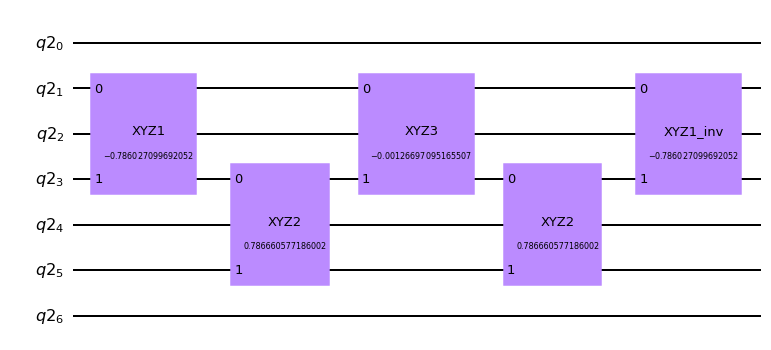

In [8]:
num_qubits = 7
qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(qr, name='Trot_pi')
Trot_qc.append(XYZ_1, [qr[1], qr[3]])
Trot_qc.append(XYZ_2, [qr[3], qr[5]])
Trot_qc.append(XYZ_3, [qr[1], qr[3]])
Trot_qc.append(XYZ_2, [qr[3], qr[5]])
Trot_qc.append(XYZ_1_inv, [qr[1], qr[3]])
Trot_qc=Trot_qc.bind_parameters({beta1:paras_pi[0],beta2:paras_pi[1], beta3:paras_pi[2]})
#Trot_qc = transpile(Trot_qc, optimization_level=3,backend=jakarta, approximation_degree=1.)
Trot_pi = Trot_qc.to_instruction()
Trot_qc.draw('mpl')

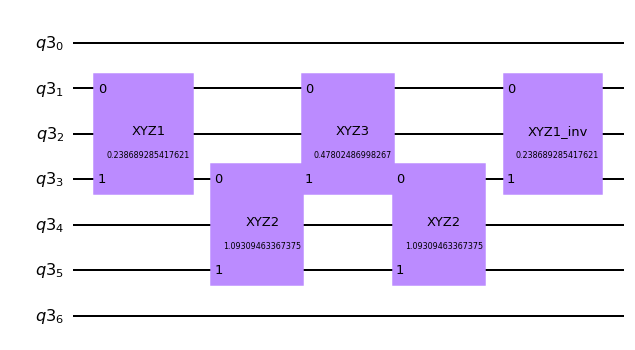

In [9]:
num_qubits = 7
qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(qr, name='Trot_half_pi')
Trot_qc.append(XYZ_1, [qr[1], qr[3]])
Trot_qc.append(XYZ_2, [qr[3], qr[5]])
Trot_qc.append(XYZ_3, [qr[1], qr[3]])
Trot_qc.append(XYZ_2, [qr[3], qr[5]])
Trot_qc.append(XYZ_1_inv, [qr[1], qr[3]])
Trot_qc=Trot_qc.bind_parameters({beta1:paras_half_pi[0],beta2:paras_half_pi[1], beta3:paras_half_pi[2]})
#Trot_qc = transpile(Trot_qc, optimization_level=3,backend=jakarta, approximation_degree=1.)
Trot_half_pi = Trot_qc.to_instruction()
Trot_qc.draw('mpl')

In [10]:
qr = QuantumRegister(7)
qc = QuantumCircuit(qr, name = "target_input")
qc.x([3,5])
qc.barrier(qr)
target_input = qc.to_instruction()

qr = QuantumRegister(7)
qc = QuantumCircuit(qr, name = "ext_input")
qc.x(3)
qc.h(5)
qc.barrier(qr)
ext_input = qc.to_instruction()

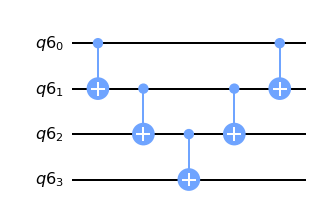

In [11]:
num_qubits = 4
qr = QuantumRegister(num_qubits)
zzz_qc = QuantumCircuit(qr, name='zzz')
zzz_qc.cnot(0, 1)
zzz_qc.cnot(1, 2)
zzz_qc.cnot(2, 3)
zzz_qc.cnot(1, 2)
zzz_qc.cnot(0, 1)
zzz = zzz_qc.to_instruction()
zzz_qc.draw('mpl')

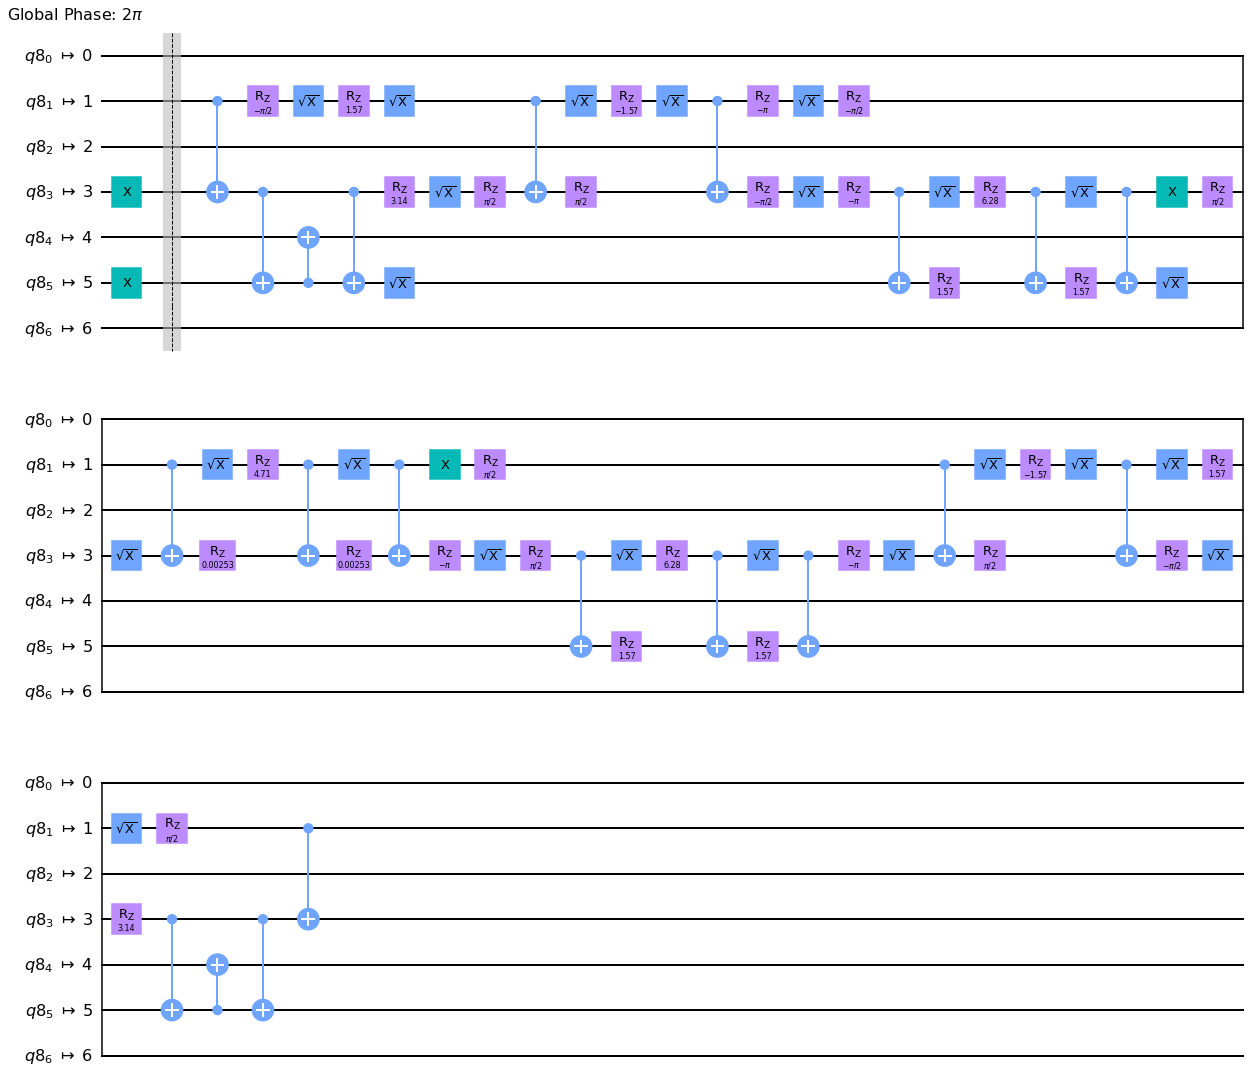

In [13]:
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

qc.append(target_input, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5], qr[6]])
qc.append(zzz, [qr[1], qr[3], qr[5], qr[4]])
qc.append(Trot_pi, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5], qr[6]])
qc.append(zzz, [qr[1], qr[3], qr[5], qr[4]])
qc_target = transpile(qc, optimization_level=3,backend=sim_noisy_jakarta, approximation_degree=1.)
qc_target.draw('mpl')

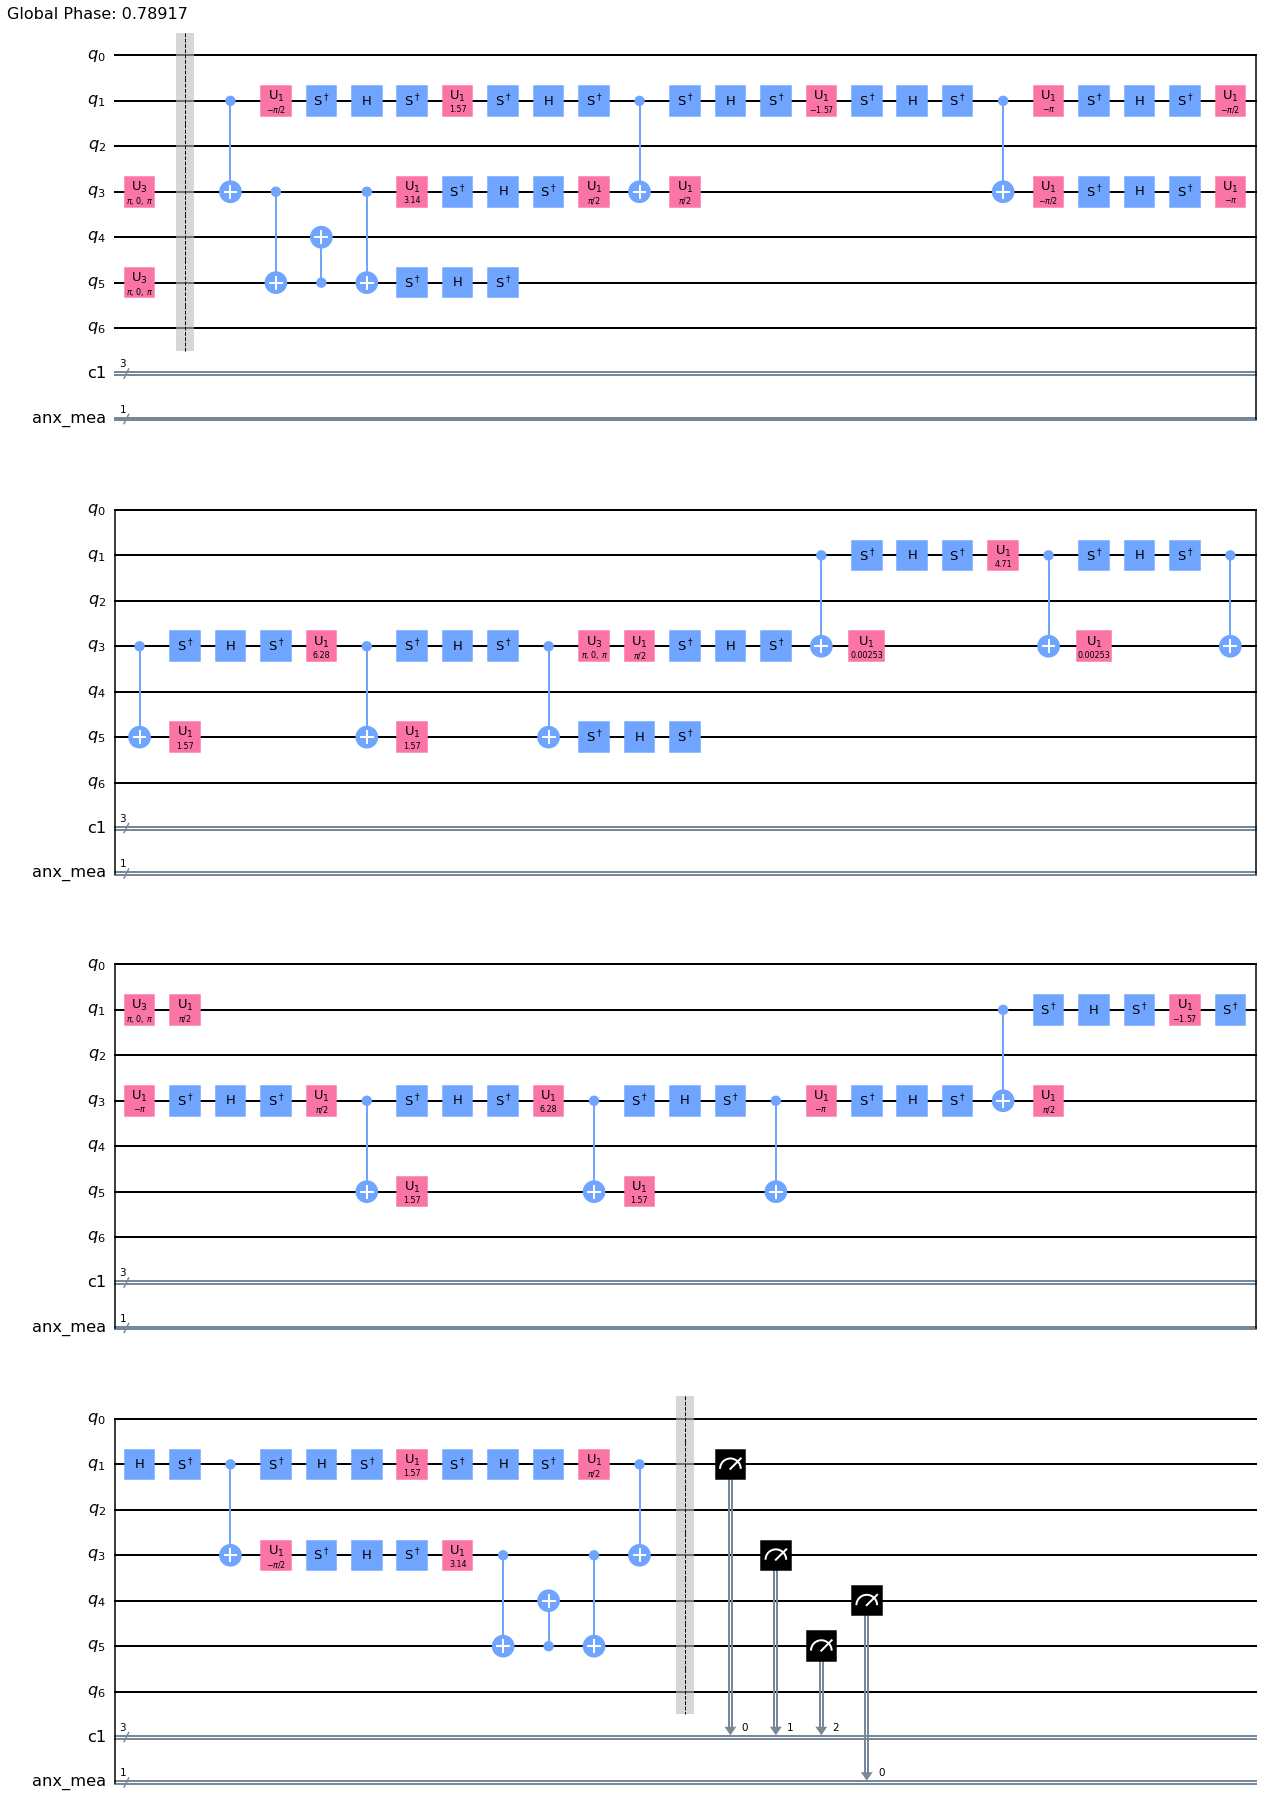

In [15]:
st_qcs_target_m = state_tomography_circuits(qc_target, [1,3,5])
st_qcs_target = []
for st_qc in st_qcs_target_m:
    st_qcs_target.append(st_qc.copy())
    cr=ClassicalRegister(1, "anx_mea")
    st_qc.add_register(cr)
    st_qc.measure([4], [cr[0]])

st_qcs_target_m[-1].decompose().draw('mpl')

In [156]:
shots = 8192
reps = 8
#backend=sim
backend = sim_noisy_jakarta.
#backend = jakarta

jobs_target = []
for _ in range(reps):
    # execute
    job = execute(st_qcs_target_m, backend, shots=shots, optimization_level=0)
    print('Job ID', job.job_id())
    jobs_target.append(job)
    

Job ID 02abbc44-6caf-4290-a7be-4c5dac3ffee3
Job ID 3ab2a3fb-6768-4edb-9798-a92dcebfdcbf
Job ID 3ea7a600-e1f3-486a-9a1a-9b13dcbf0444
Job ID 1d91f40e-1c88-434a-83f4-d3f6e3285602
Job ID 89a5c9ce-f279-4d52-a0a9-06d20d6feca4
Job ID 2a0b4f79-9476-469a-a628-83ec554a9a85
Job ID 566446b5-8dca-47d0-8a08-98409069f9be
Job ID 3bc85584-8081-4f2d-ab91-ff917a868d25


In [17]:
def state_tomo(result, st_qcs, target_state):
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    fid = state_fidelity(rho_fit, target_state)
    return fid

In [18]:
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

def get_target_state(t, initial_state):
    
    state = (U_heis3(float(t)) @ initial_state).eval()
    state = state.to_matrix()
    state = qi.Statevector(state)
    return state

In [140]:
shots =2**16
backend = sim_noisy_jakarta
#backend = jakarta
qr = QuantumRegister(7)
meas_calibs, state_labels = complete_meas_cal(qubit_list=[4, 1, 3, 5], qr=qr, circlabel='mcal')
jobs_readout = []
for _ in range(8):
    # execute
    job = execute(meas_calibs, backend, shots=shots, optimization_level=None)
    print('Job ID', job.job_id())
    jobs_readout.append(job)

print('Job ID', job.job_id())

Job ID 4f045e40-3bfa-4247-9151-a17a80f03dc2
Job ID 411c8edc-a59a-4795-8059-4646b3d5021e
Job ID 480c6b0c-66af-479e-9bf8-243c2597cbbb
Job ID 31e1dfe3-6745-4963-924c-675234a6048d
Job ID a898caee-2cce-4b61-82b7-3647e2720fd9
Job ID 17b3aa55-f6d7-4926-bfc3-b7481823062f
Job ID 4eb8c94c-290d-4297-a547-9c496f61ae24
Job ID cf2473bf-c36f-474c-9337-7592b35d1a85
Job ID cf2473bf-c36f-474c-9337-7592b35d1a85


IOStream.flush timed out
IOStream.flush timed out


In [141]:

results = [job.result() for job in jobs_readout]
meas_fitter = CompleteMeasFitter(results, state_labels, circlabel='mcal')
err_mitig = copy.deepcopy(meas_fitter)

for i in range(len(meas_fitter.state_labels)):
    state_label_raw = meas_fitter.state_labels[i]
    state_label = state_label_raw[0] + ' ' + state_label_raw[1:4]
    err_mitig.state_labels[i] = state_label

In [157]:
target_state = get_target_state(target_time ,One^One^Zero)

fids = []
for job in jobs_target:
    raw_results = job.result()
    raw_results = err_mitig.filter.apply(raw_results)
    new_results = copy.deepcopy(raw_results)
    for resultidx, _ in enumerate(raw_results.results):
        old_counts = raw_results.get_counts(resultidx)
        new_counts = {}
        new_results.results[resultidx].header.creg_sizes = [new_results.results[resultidx].header.creg_sizes[0]]
        new_results.results[resultidx].header.clbit_labels = new_results.results[resultidx].header.clbit_labels[0:-1]
        new_results.results[resultidx].header.memory_slots = 3
        
        for reg_key in old_counts:
            reg_bits = reg_key.split(' ')
            if reg_bits[0]=='0':
                new_counts[reg_bits[1]]=old_counts[reg_key]
       
        new_results.results[resultidx].data.counts = new_counts

    fid = state_tomo(new_results, st_qcs_target, target_state)
    fids.append(fid)
    
print('state tomography fidelity for target time and initial state = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity for target time and initial state = 0.8475 ± 0.0046


In [ ]:
ids= [
     "62539c5a73968c8de707cf7a",
     "62539c5c5ab79bc3fef96f68",
     "62539c5ed720334e5267f5b7",
     "62539c61cfe45cce35e5c0a3",
     "62539c6273968c7c4c07cf7b",
     "62539c64f65d787612392084",
     "62539c654b51525f2a7c8865",
     "62539c67a5d4eef9ad77eaba",
     ]
jobs_target = []
for idx in ids:
    job = jakarta.retrieve_job(idx)
    jobs_target.append(job)

In [142]:
target_state = get_target_state(target_time ,One^One^Zero)

fids = []
for job in jobs_target:
    raw_results = job.result()
    raw_results = err_mitig.filter.apply(raw_results)
    new_results = copy.deepcopy(raw_results)
    for resultidx, _ in enumerate(raw_results.results):
        old_counts = raw_results.get_counts(resultidx)
        new_counts = {}
        new_results.results[resultidx].header.creg_sizes = [new_results.results[resultidx].header.creg_sizes[0]]
        new_results.results[resultidx].header.clbit_labels = new_results.results[resultidx].header.clbit_labels[0:-1]
        new_results.results[resultidx].header.memory_slots = 3
        
        for reg_key in old_counts:
            reg_bits = reg_key.split(' ')
            if reg_bits[0]=='0':
                new_counts[reg_bits[1]]=old_counts[reg_key]
       
        new_results.results[resultidx].data.counts = new_counts

    fid = state_tomo(new_results, st_qcs_target, target_state)
    fids.append(fid)
    
print('state tomography fidelity for target time and initial state = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity for target time and initial state = 0.9224 ± 0.0045


In [23]:
def gen_dd(n, rep):

    num_qubits = 1
    dd_qr = QuantumRegister(num_qubits)
    dd_qc = QuantumCircuit(dd_qr, name='dd')
    dd_qc.barrier(0)
    for _ in range(2*rep):
        dd_qc.x(0)
        dd_qc.barrier(0)
        for _ in range(n):
            dd_qc.id(0)
            dd_qc.barrier(0)

        dd_qc.rz(-np.pi, 0)
        dd_qc.x(0)
        dd_qc.barrier(0)
        for _ in range(n):
            dd_qc.id(0)
            dd_qc.barrier(0) 
    return dd_qc

In [35]:
def dd_circuit(input_qc):

    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    dd1 = gen_dd(1, 1)
    qc.append(dd1, [qr[5]])
    qc_dd5 = transpile(qc, optimization_level=0,backend=sim_noisy_jakarta)

    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    dd2 = gen_dd(2, 1)
    qc.append(dd2, [qr[1]])
    qc_dd1 = transpile(qc, optimization_level=0,backend=sim_noisy_jakarta)

    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    dd3 = gen_dd(2, 1)
    qc.append(dd3, [qr[4]])
    qc_dd4 = transpile(qc, optimization_level=0,backend=sim_noisy_jakarta)
    
    qr = QuantumRegister(7)
    dd_qc = QuantumCircuit(qr)
    dd_qc = transpile(dd_qc, optimization_level=0,backend=sim_noisy_jakarta, approximation_degree=1.)
    dd_qc.data = input_qc.data[:11]
    for i in range(2):
        dd_qc.data += qc_dd1.data
    for i in range(3):
        dd_qc.data += qc_dd5.data
    for i in range(13):
        dd_qc.data += qc_dd4.data    
    dd_qc.data += input_qc.data[11:24] 
    for i in range(2):
        dd_qc.data += qc_dd1.data
    dd_qc.data += input_qc.data[24:36]
    for i in range(4):
        dd_qc.data += qc_dd5.data
    dd_qc.data += input_qc.data[36:48]
    for i in range(2):
        dd_qc.data += qc_dd1.data
    dd_qc.data += input_qc.data[48:57] 
    for i in range(3):
        dd_qc.data += qc_dd5.data
    dd_qc.data += input_qc.data[57:-4]
    for i in range(2):
        dd_qc.data += qc_dd1.data

    dd_qc.data += input_qc.data[-4:]
    
    return dd_qc

In [75]:
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

qc.append(zzz, [qr[1], qr[3], qr[5], qr[4]])
qc.append(Trot_pi, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5], qr[6]])
qc.append(zzz, [qr[1], qr[3], qr[5], qr[4]])
qc = transpile(qc, optimization_level=3,backend=sim_noisy_jakarta, approximation_degree=1.)
dd_qc = dd_circuit(qc)

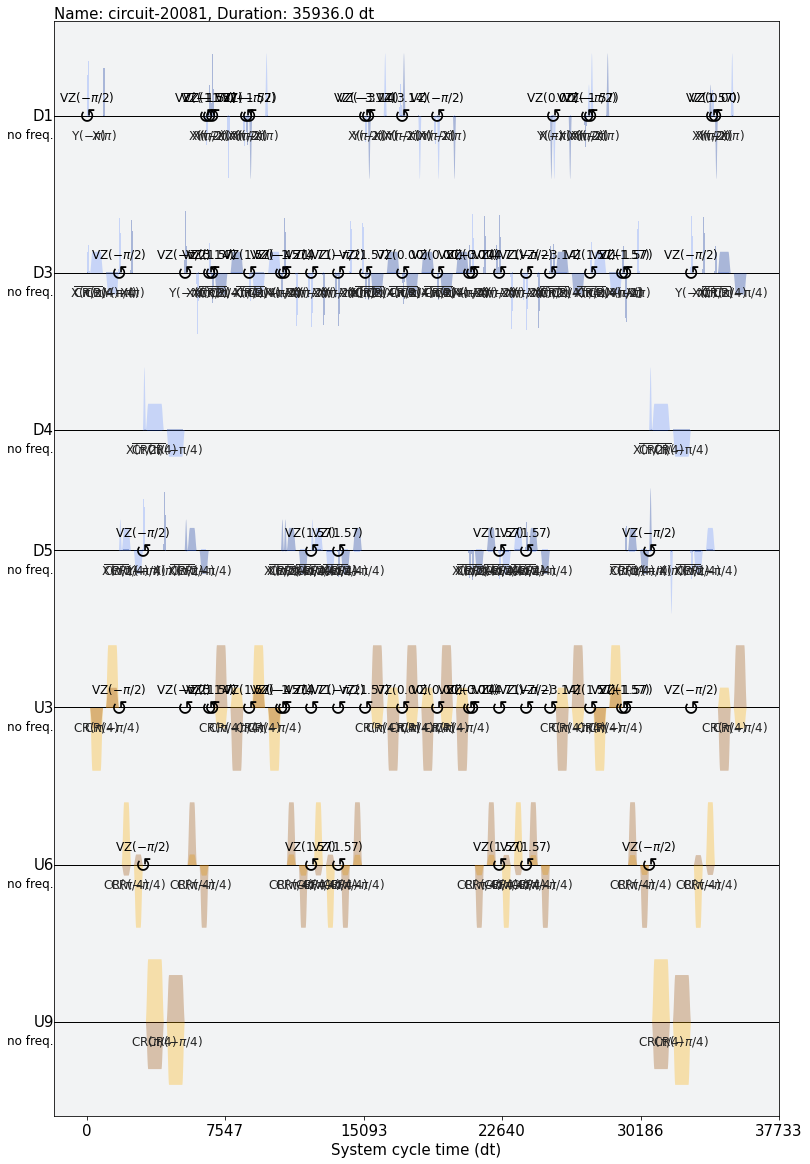

In [76]:
backend=jakarta
back_defaults = backend.defaults()
inst_map = back_defaults.instruction_schedule_map
sche = schedule(qc, backend=backend, inst_map=inst_map)
sche.draw()

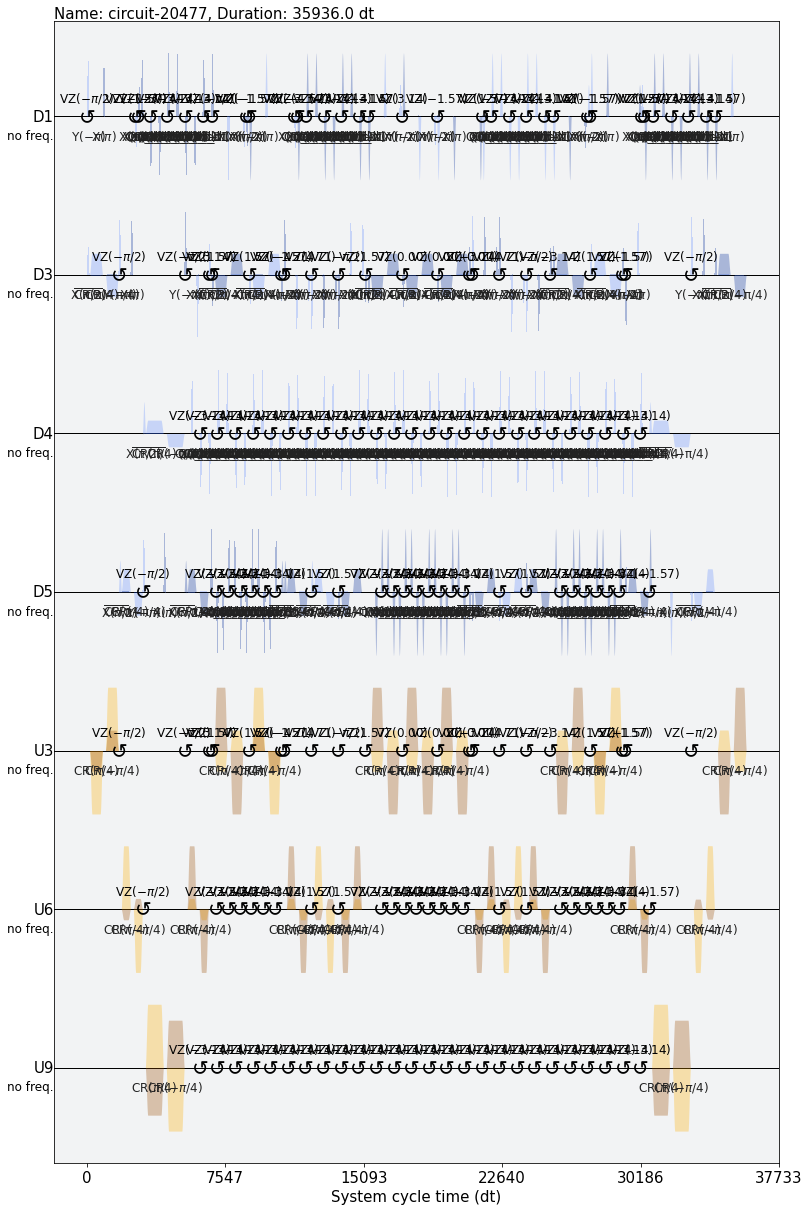

In [77]:
sche = schedule(dd_qc, backend=backend, inst_map=inst_map)
sche.draw()

In [78]:
qr = QuantumRegister(7)
dd_qc_target = QuantumCircuit(qr)
dd_qc_target.append(target_input, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5], qr[6]])
dd_qc_target = transpile(dd_qc_target, optimization_level=0,backend=sim_noisy_jakarta, approximation_degree=1.)
dd_qc_target.append(dd_qc, [0, 1, 2, 3, 4, 5, 6])

dd_st_qcs_target_m = state_tomography_circuits(dd_qc_target, [1,3,5])
dd_st_qcs_target = []
for st_qc in dd_st_qcs_target_m:
    dd_st_qcs_target.append(st_qc.copy())
    cr=ClassicalRegister(1, "anx_mea")
    st_qc.add_register(cr)
    st_qc.measure([4], [cr[0]])



In [79]:
shots = 8192
reps = 8
#backend=sim
backend = sim_noisy_jakarta
#backend = jakarta

jobs_dd_target = []
for _ in range(reps):
    # execute
    job = execute(dd_st_qcs_target_m, backend, shots=shots, optimization_level=0)
    print('Job ID', job.job_id())
    jobs_dd_target.append(job)

Job ID 33b5bbc8-8324-4067-8871-7f38d75d4c50
Job ID c79dbad2-02a0-47b8-b936-95eed29efb7f
Job ID 4ad10935-685e-4fa1-8c64-8075663671e5
Job ID 5dea1c2f-70bf-416f-a27f-0a56701563de
Job ID d4e763b7-8728-447a-a466-5c792e466fb6
Job ID b7844603-d830-45ce-9cd6-06e8cad22344
Job ID bde38c1b-f2af-4893-bdbc-2938b0e939b6
Job ID 48a2bb9c-b55f-4f58-9ee3-c9f554876583


In [143]:

ids= [
     "62539c84cfe45c1189e5c0a4",
     "62539c87a5d4eef70f77eabc",
     "62539c8bf65d785d98392085",
     "62539c8e5ab79b02c7f96f6b",
     "62539c91182d0201aa4c4714",
     "62539c9573968c52c107cf7d",
     "62539c98fdf3772f7d570f2a",
     "62539c9bcfe45c51c7e5c0a5",
     ]
jobs_dd_target = []
for idx in ids:
    job = jakarta.retrieve_job(idx)
    jobs_dd_target.append(job)

In [144]:
target_state = get_target_state(target_time ,One^One^Zero)

fids = []
for job in jobs_dd_target:
    raw_results = job.result()
    raw_results = err_mitig.filter.apply(raw_results)
    new_results = copy.deepcopy(raw_results)
    for resultidx, _ in enumerate(raw_results.results):
        old_counts = raw_results.get_counts(resultidx)
        new_counts = {}
        new_results.results[resultidx].header.creg_sizes = [new_results.results[resultidx].header.creg_sizes[0]]
        new_results.results[resultidx].header.clbit_labels = new_results.results[resultidx].header.clbit_labels[0:-1]
        new_results.results[resultidx].header.memory_slots = 3
        
        for reg_key in old_counts:
            reg_bits = reg_key.split(' ')
            if reg_bits[0]=='0':
                new_counts[reg_bits[1]]=old_counts[reg_key]
       
        new_results.results[resultidx].data.counts = new_counts

    fid = state_tomo(new_results, dd_st_qcs_target, target_state)
    fids.append(fid)
    
print('state tomography fidelity for target time and initial state with dd = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity for target time and initial state with dd = 0.9101 ± 0.0047


In [81]:
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

qc.append(zzz, [qr[1], qr[3], qr[5], qr[4]])
qc.append(Trot_half_pi, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5], qr[6]])
qc.append(zzz, [qr[1], qr[3], qr[5], qr[4]])
qc = transpile(qc, optimization_level=3,backend=sim_noisy_jakarta, approximation_degree=1.)
dd_qc = dd_circuit(qc)

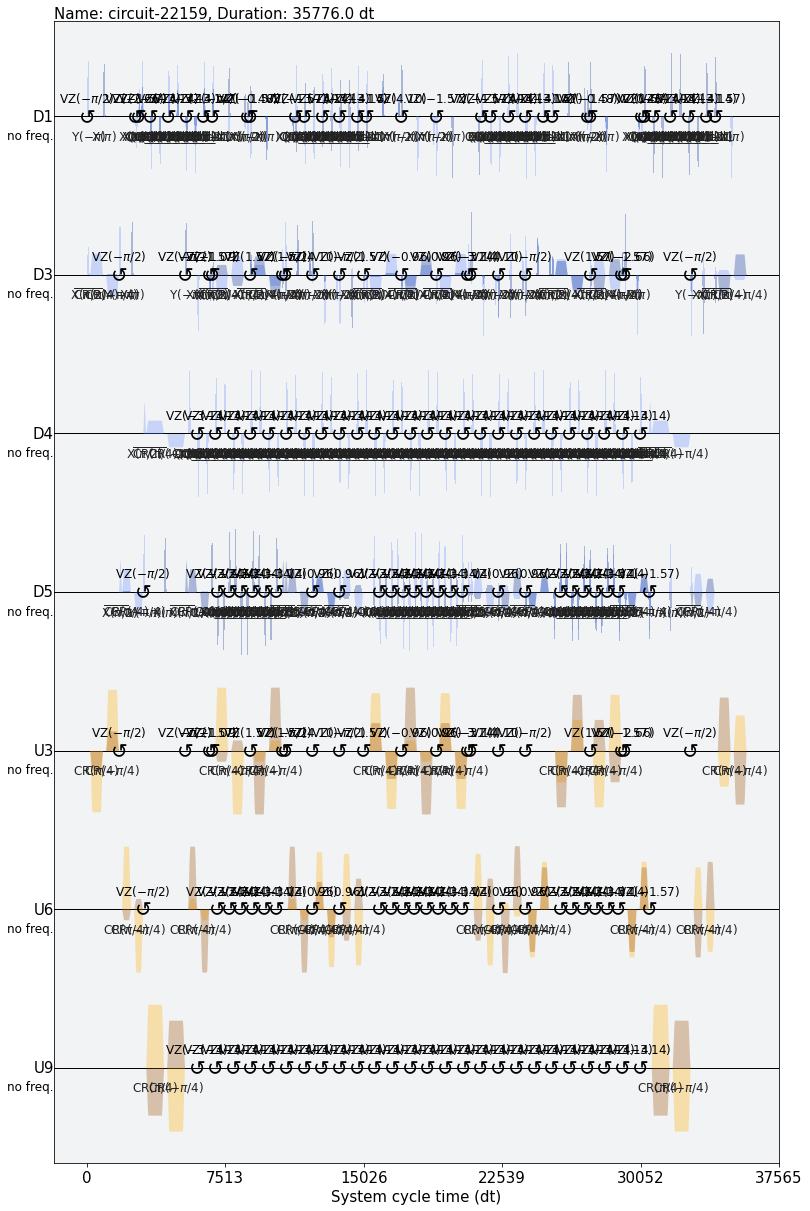

In [82]:
sche = schedule(dd_qc, backend=backend, inst_map=inst_map)
sche.draw()

In [83]:
qr = QuantumRegister(7)
dd_qc_half = QuantumCircuit(qr)
dd_qc_half.append(target_input, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5], qr[6]])
dd_qc_half = transpile(dd_qc_half, optimization_level=0,backend=sim_noisy_jakarta, approximation_degree=1.)
dd_qc_half.append(dd_qc, [0, 1, 2, 3, 4, 5, 6])

dd_st_qcs_half_m = state_tomography_circuits(dd_qc_half, [1,3,5])
dd_st_qcs_half = []
for st_qc in dd_st_qcs_half_m:
    dd_st_qcs_half.append(st_qc.copy())
    cr=ClassicalRegister(1, "anx_mea")
    st_qc.add_register(cr)
    st_qc.measure([4], [cr[0]])

In [149]:
shots = 8192
reps = 8
#backend=sim
backend = sim_noisy_jakarta
#backend = jakarta

jobs_dd_half = []
for _ in range(reps):
    # execute
    job = execute(dd_st_qcs_half_m, backend, shots=shots, optimization_level=0)
    print('Job ID', job.job_id())
    jobs_dd_half.append(job)

Job ID 3f270e4a-a8ac-4ea7-ab41-5ab1b9c89f37
Job ID e9818785-3a2e-4c7c-8405-d1e4bbe18fe3
Job ID 642a0db6-f6d4-4bbb-be50-7e4d9e689295
Job ID fa1bc2e7-430e-404f-afdd-cb7fdbdc7d0b
Job ID e72369b3-1bd6-4b0b-b132-fb4d137ab94d
Job ID 0c257e32-8f6a-4e2e-a715-548b9748f06d
Job ID 92ece41c-c9b4-4a04-9c54-9b3576408cba
Job ID 432fb47c-1d1f-49b3-b1dc-051ebe5fb068


In [152]:
target_state = get_target_state(target_time/2 ,One^One^Zero)

fids = []
for job in jobs_dd_half:
    raw_results = job.result()
    raw_results = err_mitig.filter.apply(raw_results)
    new_results = copy.deepcopy(raw_results)
    for resultidx, _ in enumerate(raw_results.results):
        old_counts = raw_results.get_counts(resultidx)
        new_counts = {}
        new_results.results[resultidx].header.creg_sizes = [new_results.results[resultidx].header.creg_sizes[0]]
        new_results.results[resultidx].header.clbit_labels = new_results.results[resultidx].header.clbit_labels[0:-1]
        new_results.results[resultidx].header.memory_slots = 3
        
        for reg_key in old_counts:
            reg_bits = reg_key.split(' ')
            if reg_bits[0]=='0':
                new_counts[reg_bits[1]]=old_counts[reg_key]
       
        new_results.results[resultidx].data.counts = new_counts

    fid = state_tomo(new_results, dd_st_qcs_half, target_state)
    fids.append(fid)
    
print('state tomography fidelity for 0.5 pi time and initial state with dd = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity for 0.5 pi time and initial state with dd = 0.7165 ± 0.0033


In [145]:

ids= [
     "62539faefdf377eaba570f4b",
     "62539fb273968c4faa07cf96",
     "62539fb5fdf3770abb570f4c",
     "62539fbaa5d4ee3b0a77ead5",
     "62539fc0cfe45cacc7e5c0c3",
     "62539fc4f65d787efa392095",
     "62539fc7182d02d2ff4c4729",
     "62539fcffdf377e751570f4d",
     ]
jobs_dd_half = []
for idx in ids:
    job = jakarta.retrieve_job(idx)
    jobs_dd_half.append(job)

In [146]:
target_state = get_target_state(target_time/2 ,One^One^Zero)

fids = []
for job in jobs_dd_half:
    raw_results = job.result()
    raw_results = err_mitig.filter.apply(raw_results)
    new_results = copy.deepcopy(raw_results)
    for resultidx, _ in enumerate(raw_results.results):
        old_counts = raw_results.get_counts(resultidx)
        new_counts = {}
        new_results.results[resultidx].header.creg_sizes = [new_results.results[resultidx].header.creg_sizes[0]]
        new_results.results[resultidx].header.clbit_labels = new_results.results[resultidx].header.clbit_labels[0:-1]
        new_results.results[resultidx].header.memory_slots = 3
        
        for reg_key in old_counts:
            reg_bits = reg_key.split(' ')
            if reg_bits[0]=='0':
                new_counts[reg_bits[1]]=old_counts[reg_key]
       
        new_results.results[resultidx].data.counts = new_counts

    fid = state_tomo(new_results, dd_st_qcs_half, target_state)
    fids.append(fid)
    
print('state tomography fidelity for 0.5 pi time and initial state with dd = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity for 0.5 pi time and initial state with dd = 0.9049 ± 0.0046


In [86]:
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

qc.append(zzz, [qr[1], qr[3], qr[5], qr[4]])
qc.append(Trot_pi, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5], qr[6]])
qc.append(zzz, [qr[1], qr[3], qr[5], qr[4]])
qc = transpile(qc, optimization_level=3,backend=sim_noisy_jakarta, approximation_degree=1.)
dd_qc = dd_circuit(qc)

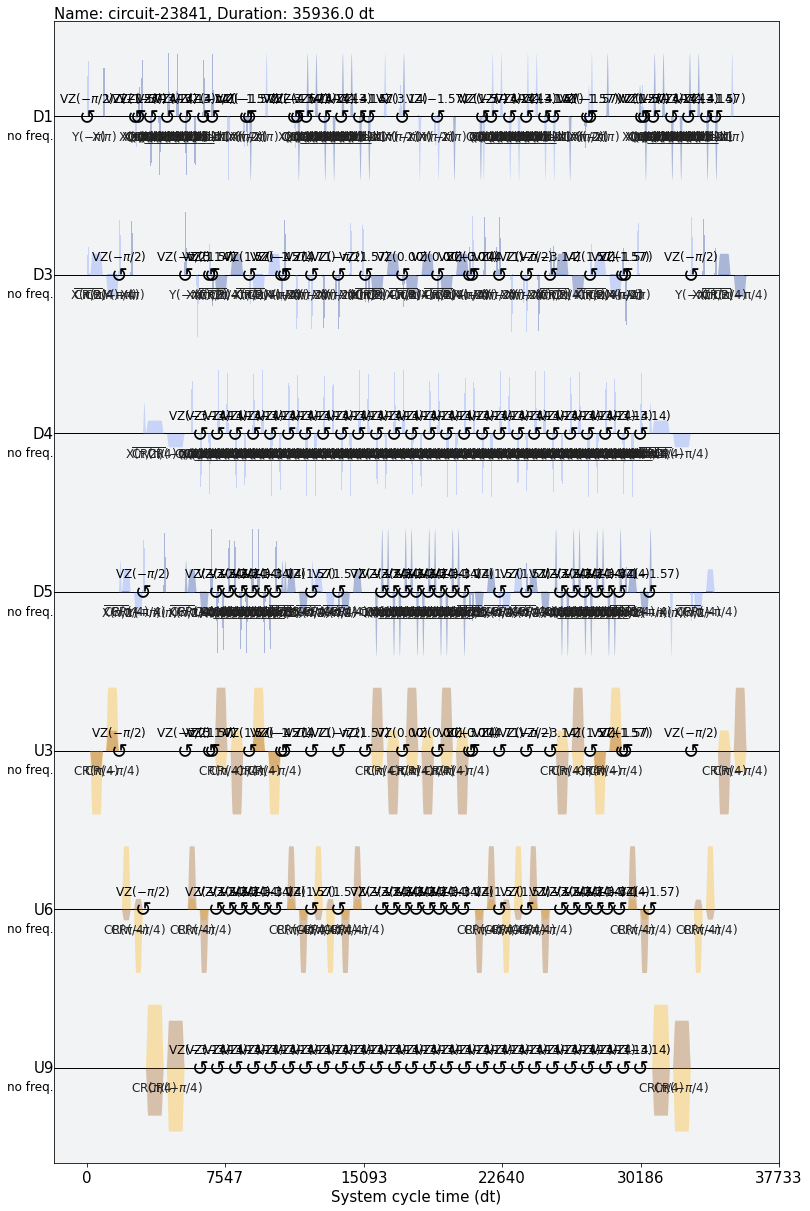

In [87]:
sche = schedule(dd_qc, backend=backend, inst_map=inst_map)
sche.draw()

In [88]:
qr = QuantumRegister(7)
dd_qc_ext = QuantumCircuit(qr)
dd_qc_ext.append(ext_input, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5], qr[6]])
dd_qc_ext = transpile(dd_qc_ext, optimization_level=0,backend=sim_noisy_jakarta, approximation_degree=1.)
dd_qc_ext.append(dd_qc, [0, 1, 2, 3, 4, 5, 6])

dd_st_qcs_ext_m = state_tomography_circuits(dd_qc_ext, [1,3,5])
dd_st_qcs_ext = []
for st_qc in dd_st_qcs_ext_m:
    dd_st_qcs_ext.append(st_qc.copy())
    cr=ClassicalRegister(1, "anx_mea")
    st_qc.add_register(cr)
    st_qc.measure([4], [cr[0]])

In [92]:
shots = 8192
reps = 8
#backend=sim
backend = sim_noisy_jakarta
#backend = jakarta

jobs_dd_ext = []
for _ in range(reps):
    # execute
    job = execute(dd_st_qcs_ext_m, backend, shots=shots, optimization_level=0)
    print('Job ID', job.job_id())
    jobs_dd_ext.append(job)

Job ID c7b12f7e-8fd3-4655-9d5b-e5d8a2f98d99
Job ID 33a15ddd-0070-4d41-9f7d-87790ace2e6d
Job ID 9880bb3b-28ca-4eae-b42e-2086c226a33c
Job ID 31af64a8-1d88-411f-a2c1-bf0c09c5ae6d
Job ID 007a587d-7055-4385-97c1-0c155bbe367f
Job ID e5533518-57c6-4d0a-8221-39097c3ee699
Job ID 90e71170-14f6-4b6f-9e06-520849375551
Job ID e88aa350-c917-4aa1-ab98-505e71477bdc


In [147]:

ids= [
      "6253a1ef73968c7c8007cfac",
      "6253a1f5182d0251634c4735",
      "6253a1fbcaa265193af1b7cb",
      "6253a1fef65d7851173920a6",
      "6253a2014b5152f8027c8889",
      "6253a206fdf3772ca7570f5e",
      "6253a20bcaa2658ceaf1b7cc",
      "6253a211fdf3775364570f5f",
      ]
jobs_dd_ext = []
for idx in ids:
    job = jakarta.retrieve_job(idx)
    jobs_dd_ext.append(job)

In [148]:
target_state = get_target_state(target_time ,((Zero+One)/np.sqrt(2))^One^Zero)

fids = []
for job in jobs_dd_ext:
    raw_results = job.result()
    raw_results = err_mitig.filter.apply(raw_results)
    new_results = copy.deepcopy(raw_results)
    for resultidx, _ in enumerate(raw_results.results):
        old_counts = raw_results.get_counts(resultidx)
        new_counts = {}
        new_results.results[resultidx].header.creg_sizes = [new_results.results[resultidx].header.creg_sizes[0]]
        new_results.results[resultidx].header.clbit_labels = new_results.results[resultidx].header.clbit_labels[0:-1]
        new_results.results[resultidx].header.memory_slots = 3
        
        for reg_key in old_counts:
            reg_bits = reg_key.split(' ')
            if reg_bits[0]=='0':
                new_counts[reg_bits[1]]=old_counts[reg_key]
       
        new_results.results[resultidx].data.counts = new_counts

    fid = state_tomo(new_results, dd_st_qcs_ext, target_state)
    fids.append(fid)
    
print('state tomography fidelity for target time and |110> + |010> superposition state with dd = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity for target time and |110> + |010> superposition state with dd = 0.8896 ± 0.0066


In [96]:
# extrapolation